# Baseline Model Implementation: Logistic Regression & Decision Tree

#### 5. Algorithm Exploration and Evaluation
##### &nbsp;&nbsp;&nbsp;&nbsp;5.2 Discussion on Viable Algorithms
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.1 Model 1: Logistic Regrssion
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2.2 Model 2: Graident Boosted Trees
##### &nbsp;&nbsp;&nbsp;&nbsp;5.3 Applying Baseline Algorithms to Validation Datset
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.1 Balancing Dataset 
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.2 Logistic Regression Pipeline
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.3 Gradient Boosted Trees Pipeline
##### &nbsp;&nbsp;&nbsp;&nbsp;5.4 Initial Validation of Baseline Models
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.4.1 Precision, Recall, Accuracy, PR AUC, ROC AUC, F1 and F2 Metrics
##### &nbsp;&nbsp;&nbsp;&nbsp;5.5 Model Performance Results
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.5.1 Logistic Regrssion
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.5.2 Graident Boosted Trees


#### 6. XGB Pipeline Implementation and Optimization on Full Dataset
##### &nbsp;&nbsp;&nbsp;&nbsp;6.1 Final Model: XGBoost
##### &nbsp;&nbsp;&nbsp;&nbsp;6.2 Applying XGBoosted Trees on Dataset
##### &nbsp;&nbsp;&nbsp;&nbsp;6.3 Discussion on XGBoost Evaluation and Optimization Methodology
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.3.1 Evaluation and Tuning with Timeseries Dataset with k-fold Timeseries Cross Validation
##### &nbsp;&nbsp;&nbsp;&nbsp;6.4 Validation Results with XGBoost
##### &nbsp;&nbsp;&nbsp;&nbsp;6.5 Final Modeling using 2019 Test Dataset

### Imports

In [0]:

# Basic Functions
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType, TimestampType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
 
# For plotting & basic funcs
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from math import floor
import itertools 
 
# For Modeling
from pyspark.ml.classification import MultilayerPerceptronClassifier, LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
from sparkdl.xgboost import XgboostClassifier
from sklearn.metrics import precision_recall_curve, roc_curve


sqlContext = SQLContext(sc)


In [0]:
# init blob import scripts

blob_container = "finalproj" # The name of your container created in https://portal.azure.com
storage_account = "w261team13" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team13finalproj" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team13saskey" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"


# configure SAS token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# read from blob storage
# use translation table from github: https://github.com/datasets/airport-codes/blob/master/data/airport-codes.csv
file_location = f"{blob_url}/*"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

df_codes = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)



In [0]:
# Read from preprocessed eda dataset that includes categorical features
df_ = spark.read.option("header", "true").parquet(f"blob_url/full_combined_dataset_final_eda/*")
# df_ = spark.read.option("header", "true").parquet(f"blob_url/3m_combined_dataset_final/*")
# df_ = spark.read.option("header", "true").parquet(f"blob_url/full_combined_dataset/*")
display(df_.limit(10))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEP_TIME DEP_DELAY_NEW DEP_DEL15 ARR_TIME ARR_DEL15 CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY AA1 AJ1 AL1 AO1 CB1 CF3 CG1 CT1 CU1 CV2 CW1 DEW ED1 ELEVATION GA2 GD2 GO1 IA1 KA1 KB1 KD2 MD1 ME1 MV2 MW1 RH3 SLP TMP VIS WA1 WD1 counter count_of_flights rolling_7d_average_number_of_flights rolling_7d_average_percent_flights_delayed rolling_7d_average_flights_distance OP_UNIQUE_CARRIER_index carrier_vec originid_vec destid_vec dayofweek_vec month_vec quarter_vec 2018 1 1 1 1 2018-01-01 9E 11298 1129806 12478 1247805 900 0.0 0.0 1309 0.0 0.0 0.0 214.0 189.0 1391.0 6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1 1 0.14285714285714285 0.0 1391.0 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(12478), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 13487 1348702 1139 0.0 0.0 1405 0.0 0.0 0.0 156.0 146.0 852.0 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -122.0 0.0 170.7 0.0 0.0 0.0 0.0 -44.0 0.0 0.0 7.0 0.0 0.0 0.0 0.0 10374.0 -44.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(13487), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 11193 1119302 1833 0.0 0.0 2138 0.0 0.0 0.0 134.0 125.0 812.0 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -144.0 0.0 170.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10352.0 -28.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11193), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 11433 1143302 1307 0.0 0.0 1735 1.0 0.0 0.0 162.0 208.0 986.0 4 0.0 0.0 43.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -122.0 0.0 170.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10373.0 -44.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11433), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 12478 12

In [0]:
# Reusing data cleaning from the other notebook
df_ = df_.drop("CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "ARR_DEL15", "DEP_DELAY_NEW")
df_ = df_.withColumnRenamed("DEP_DEL15", "label")

In [0]:
display(df_)
df_train = df_.filter(df_['YEAR'] == 2015)
df_validate = df_.filter(df_['YEAR'] == 2016)
df_train_ful = df_.filter(df_['YEAR'] < 2019)
df_test = df_.filter(df_['YEAR'] == 2019)
trainCount = df_train.count()
positiveTrainCount = df_train.filter(df_train['label'] == 1).count()
negativeTrainCount = df_train.filter(df_train['label'] == 0).count()
print(positiveTrainCount, negativeTrainCount)

## Baseline 1: Logistic Regression

In [0]:
# Read dataset
# train for 2015~2017
full_training_df = df_.filter(f.col('year') < 2018)
# test with 2018
final_test_df = df_.filter(f.col('year') == 2018)

In [0]:
# create class weights using ratio of delayed/total flight
delayed_flights = full_training_df.selectExpr("label").filter(col("label") == 1)
sample_ratio = delayed_flights.count() / full_training_df.count() 
delayed_weight = 1 - sample_ratio
ontime_weight = sample_ratio

weighted_full_training_df = full_training_df.withColumn("label_weight", when(full_training_df.label == 1, delayed_weight).otherwise(ontime_weight))

print('delay ratio: %.4f' %sample_ratio)

# create basseline LR model, use reg param of 0.1
base_lr = LogisticRegression(regParam=0.1, weightCol="label_weight")

In [0]:
# put model through pipeline
columns_numerical = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           

assembler_cont = VectorAssembler(inputCols = columns_numerical, outputCol="cont_features")

scaler = StandardScaler(inputCol = "cont_features", outputCol="scaled_cont_features", withStd=True, withMean=True)

columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]

indexer = StringIndexer(inputCols = columns_categorical, outputCols = [c+"_indexed" for c in columns_categorical], handleInvalid='keep')

ohe = OneHotEncoder(inputCols = [c+"_indexed" for c in columns_categorical], outputCols = [c+"_OHE" for c in columns_categorical])

assembler_categ = VectorAssembler(inputCols = [x+"_OHE" for x in columns_categorical], outputCol="cat_features")

selector = ChiSqSelector(fpr=0.05, selectorType='fpr', featuresCol="cat_features", outputCol="selected_cat_features", labelCol="label")

assembler = VectorAssembler(inputCols= ["selected_cat_features", "scaled_cont_features"], outputCol="features")

pipeline_base_lr = Pipeline(stages=[assembler_cont, scaler, indexer, ohe, assembler_categ, selector, assembler, base_lr]) 



In [0]:
# fit model to pipeline
baseline_lr_model = pipeline_base_lr.fit(weighted_full_training_df)

In [0]:
# Predict with test data
train_pred = baseline_lr_model.transform(full_training_df)
test_pred = baseline_lr_model.transform(final_test_df)


'df.filter''df.filter''df.filter'Baseline Logistic Regression
 Train Test
PR AUC 0.37882 0.38413
ROC AUC 0.73088 0.72635
F1 Score 0.41995 0.41924
F2 Score 0.54200 0.54805
Recall 0.67225 0.68922
Precision 0.30535 0.30124
Accuracy 0.66823 0.64974
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

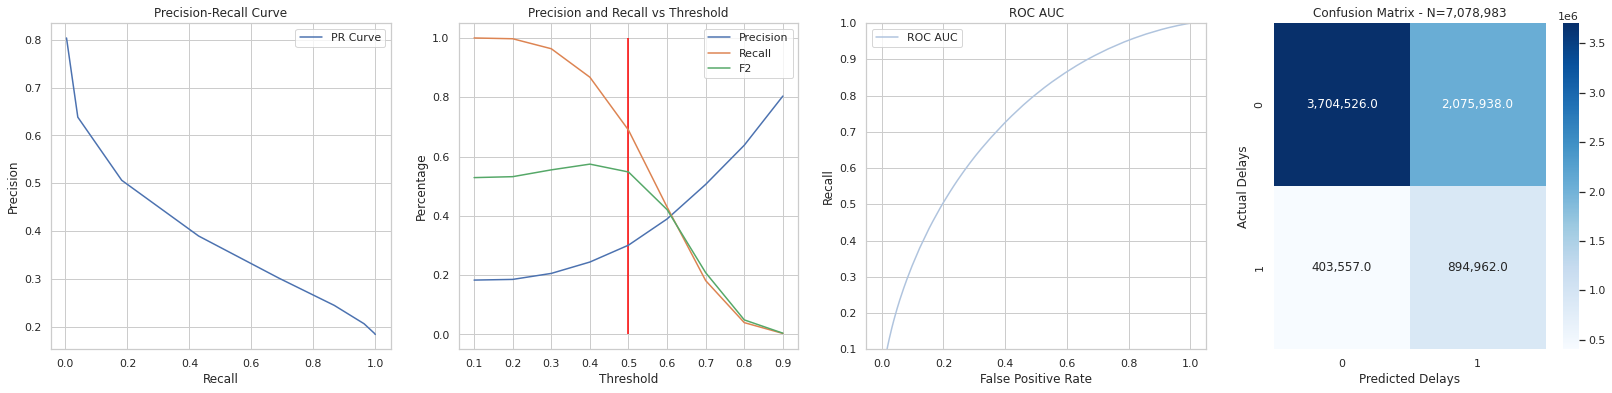

In [0]:
# evaluate baseline LR model
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Baseline Logistic Regression")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

# udf to take first position of the venctor
firstelement = udf(lambda item:float(item[1]), FloatType())

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

# plot results PR curve, ROC AUC and confusion matrix
# plot the Precision-Recall curve  
sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

class CurveMetrics(BinaryClassificationMetrics):
  ''' Helper function to plot roc curve - reference: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve '''
  
  def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
  def _to_list(self, rdd):
      points = []
      for row in rdd.collect():
          points += [(float(row._1()), float(row._2()))]
      return points
  def get_curve(self, method):
      rdd = getattr(self._java_model, method)().toJavaRDD()
      return self._to_list(rdd)

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


## Baseline 2: Decision Tree - GBT

In [0]:
# pull data for training and validation
full_training_df = df_.filter(f.col('year') < 2018)
final_test_df = df_.filter(f.col('year') == 2018)

# downsample dataset to balance it out
delay_count = full_training_df.filter(f.col("label") == 1).count()
non_delay_count = full_training_df.filter(f.col("label") == 0).count()

keep_percent = delay_count / non_delay_count

train_delay = full_training_df.filter(f.col('label') == 1)
train_non_delay = full_training_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
weighted_full_training_df = train_delay.union(train_non_delay)

# create baseline gbt
base_gbt = GBTClassifier(maxDepth=5, maxBins=350, maxIter=5, stepSize=0.13)

In [0]:
# pipeline for baseline gbt
# Continuous features to scale
columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           

assembler_cont = VectorAssembler(inputCols = columns_numeric, outputCol = "cont_features")

# categorical features that need to be indexed and then ohe
columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]

indexer = StringIndexer(inputCols = columns_categorical, outputCols = [c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])

assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")

assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

pipeline_base_gbt = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, base_gbt])  

In [0]:
# fit the baseline gbt model with balaned training dataset
baseline_gbt_model = pipeline_base_gbt.fit(weighted_full_training_df)

In [0]:
# train and predict validation dataset
train_pred = baseline_gbt_model.transform(full_training_df)
test_pred = baseline_gbt_model.transform(final_test_df)

Baseline Gradient Boosted Tree
 Train Test
PR AUC 0.42041 0.42801
ROC AUC 0.75002 0.75023
F1 Score 0.42837 0.43215
F2 Score 0.56224 0.57050
Recall 0.71022 0.72531
Precision 0.30667 0.30776
Accuracy 0.66137 0.65036
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

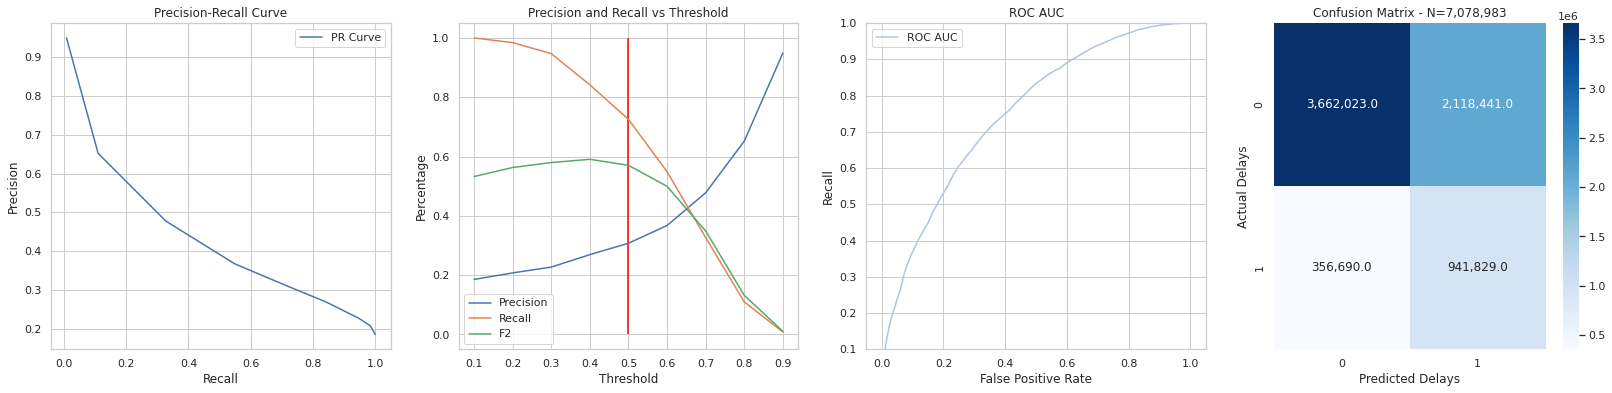

In [0]:
# evaluate baseline gbt model
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Baseline Gradient Boosted Tree")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


### POC for optimizing GBT using timeseries k-fold cross validation#
#### attempt 1. 'maxDepth': [7,8] 'maxBins': [280,430], 'maxIter': [5], 'stepSize': [0.2]

In [0]:
# Track best performance for each hyperparamters
curr_best_score = 0
curr_best_param = None

# k-fold size
k = 3

df=full_training_df
n=df.count()
df = df.withColumn("row_id", f.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
chunk_size = int(n/(k+1))

# get parameter sets, param range preselected after randomsearch
paramgrid_gbt = {'maxDepth':[7,8], 'maxBins': [280,430], 'maxIter': [5], 'stepSize': [0.2]}

param_names = list(paramgrid_gbt.keys())
v = paramgrid_gbt.values()
parameters = list(itertools.product(*v))


print('\n')
print(f'Validation datapoints for each fold: {chunk_size:,}')
print("=========================================================")

for p in parameters:
  # create pipeline for each hyperparameter combinations
  p_gbt = GBTClassifier(maxDepth=p[0], maxBins=p[1], maxIter=p[2], stepSize=p[3])
  
  columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           
  
  assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
  
  columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
  
  indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
  
  ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
  
  assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
  
  assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

  pipeline = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, p_gbt]) 
  

  # Print parameter set
  param_print = {x[0]:x[1] for x in zip(param_names,p)}
  print(f"Parameters: {param_print}")
  scores=[]

  # Start k-fold
  for i in range(k):

    # TimeseriesSplit 
    train_df = df.filter(f.col('row_id') <= chunk_size * (i+1)).cache()
    # Create dev set
    dev_df = df.filter((f.col('row_id') > chunk_size * (i+1))&(f.col('row_id') <= chunk_size * (i+2))).cache()
    
    # downsample dataset to balance it out
    delay_count = train_df.filter(f.col("label") == 1).count()
    non_delay_count = train_df.filter(f.col("label") == 0).count()
    keep_percent = delay_count / non_delay_count
    train_delay = train_df.filter(f.col('label') == 1)
    train_non_delay = train_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
    train_df = train_delay.union(train_non_delay)

    # Fit params on the model
    model = pipeline.fit(train_df)
    dev_pred = model.transform(dev_df)
    rdd_preds_multi = dev_pred.select(['prediction', 'label']).rdd
    # evaluate model
    metrics_multi = MulticlassMetrics(rdd_preds_multi)
    F2 = np.round(metrics_multi.fMeasure(label=1.0, beta=2.0), 5)
    scores.append(F2)
    print(f'    Number of training datapoints for fold #{i+1}: {train_df.count():,} with a F2 score of {F2:.2f}') 
    print('------------------------------------------------------------')
    # Set best parameter set to current one for first fold
    if curr_best_param == None:
      curr_best_param = p

  # Take average of all scores
  avg_score = np.average(scores)    
  # Update best score and parameter
  if avg_score > curr_best_score:
    previous_best = curr_best_score
    curr_best_score = avg_score
    best_parameters = param_print
    curr_best_param = p
    print(f'new best score of {curr_best_score:.2f}')
  else:
    print(f'SKIP - score was {avg_score:.2f} with best F2 score {curr_best_score:.2f}')
  print("=============================================================================")

print('best parameters from CV with validation dataset:')
print(best_parameters, curr_best_score)

In [0]:
gbt_best_parameters = {'maxDepth': 5, 'maxBins': 350, 'maxIter': 6, 'stepSize': 0.13}
gbt_best_score = 0.57
print(f'best parameters : {gbt_best_parameters}, best score: {gbt_best_score}')


best parameters : {'maxDepth': 5, 'maxBins': 350, 'maxIter': 6, 'stepSize': 0.13}, best score: 0.57

In [0]:
best_params = list(best_parameters.values())
best_gbt = GBTClassifier(maxDepth=best_params[0], maxBins=best_params[1], maxIter=best_params[2], stepSize=best_params[3])

# create pipeline for GBT
columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           
assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

pipeline_best_gbt = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, best_gbt]) 
 
# model = pipeline.fit(train_df)
best_gbt_model = pipeline_best_gbt.fit(weighted_full_training_df)

# transform and predict
train_pred = best_gbt_model.transform(full_training_df)
test_pred = best_gbt_model.transform(final_test_df)

# return best_gbt_model, test_pred

Best Gradient Boosted Tree
 Train Test
PR AUC 0.44838 0.45085
ROC AUC 0.76338 0.76104
F1 Score 0.44170 0.44357
F2 Score 0.56675 0.57431
Recall 0.69860 0.71475
Precision 0.32295 0.32157
Accuracy 0.68451 0.67107
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

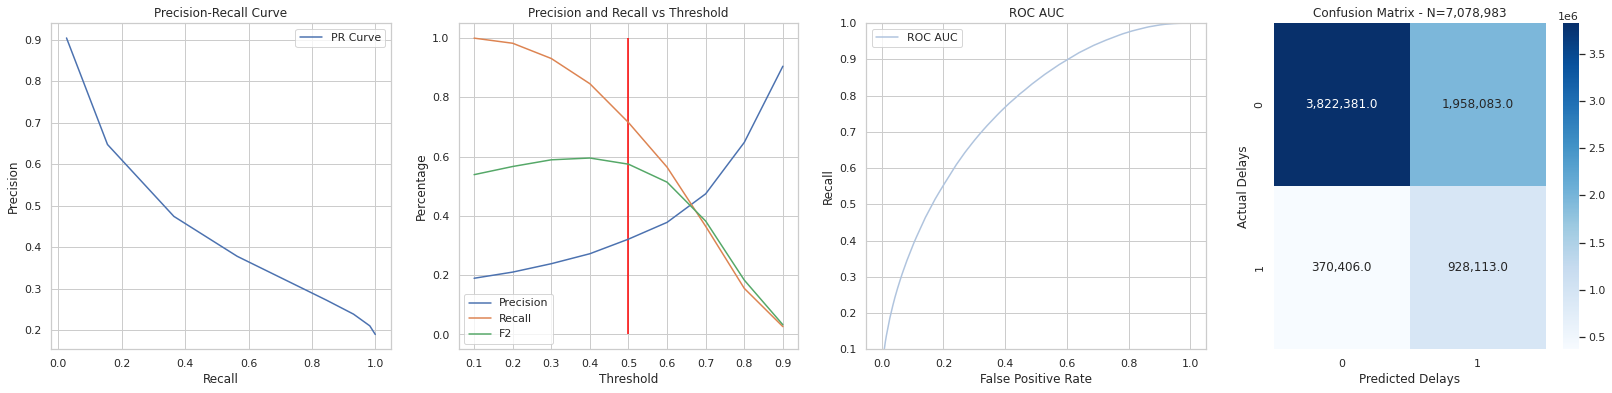

In [0]:
# evaluate best hyperparameter model using PR ROC AUC and other metrics 
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Best Gradient Boosted Tree")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


#### GBT feature importance

{1861: 'cont_features_YEAR', 1862: 'cont_features_QUARTER', 1863: 'cont_features_MONTH', 1864: 'cont_features_DAY_OF_MONTH', 1865: 'cont_features_DAY_OF_WEEK', 1866: 'cont_features_DEP_TIME', 1867: 'cont_features_ARR_TIME', 1868: 'cont_features_CANCELLED', 1869: 'cont_features_DIVERTED', 1870: 'cont_features_CRS_ELAPSED_TIME', 1871: 'cont_features_ACTUAL_ELAPSED_TIME', 1872: 'cont_features_DISTANCE', 1873: 'cont_features_DISTANCE_GROUP', 1874: 'cont_features_AA1', 1875: 'cont_features_AJ1', 1876: 'cont_features_AL1', 1877: 'cont_features_AO1', 1878: 'cont_features_CB1', 1879: 'cont_features_CF3', 1880: 'cont_features_CG1', 1881: 'cont_features_CT1', 1882: 'cont_features_CU1', 1883: 'cont_features_CV2', 1884: 'cont_features_CW1', 1885: 'cont_features_DEW', 1886: 'cont_features_ED1', 1887: 'cont_features_ELEVATION', 1888: 'cont_features_GA2', 1889: 'cont_features_GD2', 1890: 'cont_features_GO1', 1891: 'cont_features_IA1', 1892: 'cont_features_KA1', 1893: 'cont_features_KB1', 1894: 'cont_features_KD2', 1895: 'cont_features_MD1', 1896: 'cont_features_ME1', 1897: 'cont_features_MV2', 1898: 'cont_features_MW1', 1899: 'cont_features_RH3', 1900: 'cont_features_SLP', 1901: 'cont_features_TMP', 1902: 'cont_features_VIS', 1903: 'cont_features_WA1', 1904: 'cont_features_WD1', 1905: 'cont_features_count_of_flights', 1906: 'cont_features_rolling_7d_average_number_of_flights', 1907: 'cont_features_rolling_7d_average_percent_flights_delayed', 1908: 'cont_features_rolling_7d_average_flights_distance', 0: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10397', 1: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13930', 2: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12892', 3: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11292', 4: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11298', 5: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14771', 6: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12889', 7: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14107', 8: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12266', 9: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13204', 10: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11618', 11: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14747', 12: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10721', 13: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13487', 14: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11433', 15: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11057', 16: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12478', 17: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12953', 18: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10821', 19: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14869', 20: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13232', 21: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11697', 22: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14679', 23: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13303', 24: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11259', 25: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11278', 26: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14100', 27: 'cat_features_ORIGIN_AIRPORT_ID_OHE_15304', 28: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12191', 29: 'cat_features_ORIGIN_AIRPORT_ID_OHE_15016', 30: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14057', 31: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10693', 32: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13796', 33: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10423', 34: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14831', 35: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13495', 36: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14893', 37: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13198', 38: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14908', 39: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12173', 40: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12264', 41: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14492', 42: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11042', 43: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14683', 44: 'cat_features_ORIGIN_AIRPORT_ID_OHE_13342', 45: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14635', 46: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14843', 47: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14027', 48: 'cat_features_ORIGIN_AIRPORT_ID_OHE_12339', 49: 'cat_features_ORIGIN_AIRPORT_ID_OHE_14122', 50: 'cat_features_ORIGIN_AIRPORT_ID_OHE_11066', 51: 'cat_features_ORIGIN_AIRPORT_ID_OHE_10800', 52: 

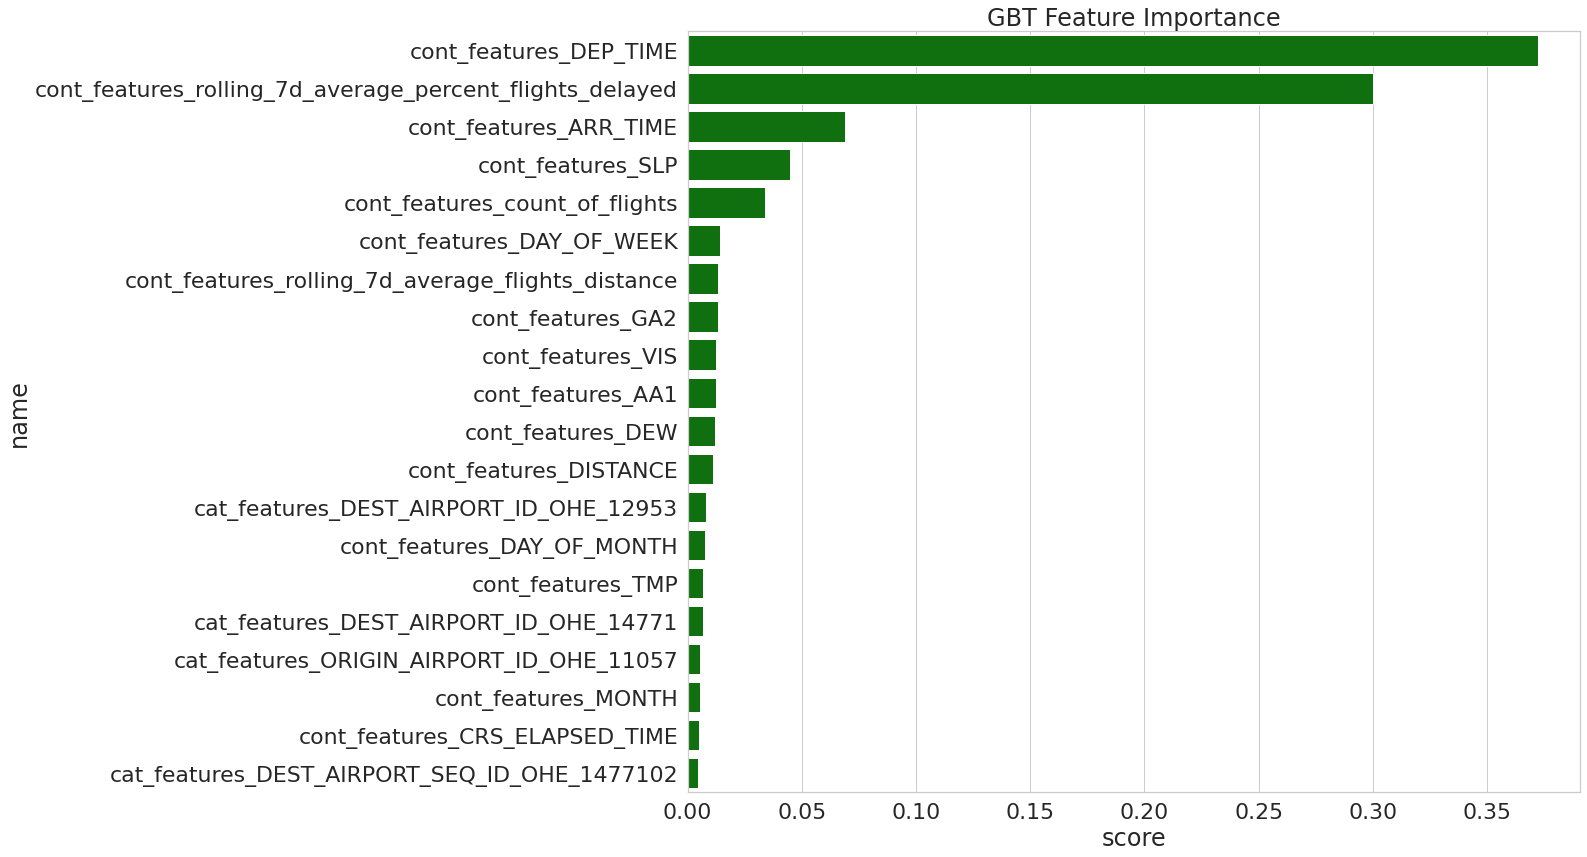

Text(0.5, 1.0, 'GBT Feature Importance')

In [0]:
# checking what features improves the model the most
feature_names = test_pred.schema["features"].metadata["ml_attr"]["attrs"]
# print all features
dict_feature_names={}
for key in feature_names.keys():
  for i in range(len(feature_names[key])):
    dict_feature_names[feature_names[key][i]['idx']]= feature_names[key][i]['name']

featureNames = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
# get featureimportance in gbt
importance = best_gbt_model.stages[-1].featureImportances
imp = pd.DataFrame(importance.toArray())
for col in imp.columns: 
    print(col) 
imp.rename( columns={0:'score'}, inplace=True )
# sort and merge
df1 = imp.sort_values('score',ascending = False).head(20)
df1 = df1.reset_index()
df2 = pd.merge(featureNames, df1, on='index')
df2 = df2.sort_values('score', ascending=False)
# plot barchart for importance
sns.set(font_scale=2, style='whitegrid')
plt.subplots(figsize=(16,14))
ax = sns.barplot(x='score', y='name', data=df2, color='green')
ax.set_xlabel('score')
ax.set_title('GBT Feature Importance')


### Improved Model: XGBoost
#### Attempt 1. 'max_depth':[3,6], 'n_estimators':[100,150], 'learning_rate':[0.2, 0.3], 'scale_pos_weight':[2,3]

In [0]:
# Timeseries Crossvalidation

# track best performace for each hyperparameter set
curr_best_score = 0
curr_best_param = None

# k-fold size
k = 2

df=full_training_df
n = df.count()
df = df.withColumn("row_id", f.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
chunk_size = int(n/(k+1))

# get parameter sets in consideration
paramGrid_xgboost = {'max_depth':[3,6], 'n_estimators':[100,150], 'reg_lambda':[1], 'reg_alpha':[0], 'objective':['binary:logistic'], 'base_score':[0.5], 'learning_rate':[0.2, 0.3], 'gamma':[0.05],
                     'scale_pos_weight':[2,3], 'min_child_weight':[1.5]}
param_names = list(paramGrid_xgboost.keys())
v = paramGrid_xgboost.values()
parameters = list(itertools.product(*v))


print('')
print(f'validation datapoints for each fold: {chunk_size:,}')
print("=========================================================")

for p in parameters:
  xgboost = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability', max_depth=p[0], n_estimators=p[1], reg_lambda=p[2], reg_alpha=p[3], objective=p[4],
                              base_score = p[5], learning_rate = p[6], gamma = p[7], scale_pos_weight = p[8],min_child_weight = p[9])
  # pipeline for XGBoost
  columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]    
  
  assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
  
  columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
  
  indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
  
  ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
  
  assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
  
  assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

  pipeline_base_xgb = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, xgboost]) 

  # Print parameter set
  param_print = {x[0]:x[1] for x in zip(param_names,p)}
  print(f"Parameters: {param_print}")
  scores=[]

  # Start k-fold
  for i in range(k):

    # TimeseriesSplit 
    train_df = df.filter(f.col('row_id') <= chunk_size * (i+1)).cache()
    # Create dev set
    dev_df = df.filter((f.col('row_id') > chunk_size * (i+1))&(f.col('row_id') <= chunk_size * (i+2))).cache()  
    
    # downsample dataset to make a balanced training dataset
    delay_count = train_df.filter(f.col("label") == 1).count()
    non_delay_count = train_df.filter(f.col("label") == 0).count()
    keep_percent = delay_count / non_delay_count
    train_delay = train_df.filter(f.col('label') == 1)
    train_non_delay = train_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
    train_df = train_delay.union(train_non_delay)

    # Fit params on the model
    model = pipeline.fit(train_df)
    dev_pred = model.transform(dev_df)
    rdd_preds_multi = dev_pred.select(['prediction', 'label']).rdd
    metrics_multi = MulticlassMetrics(rdd_preds_multi)
    F2 = np.round(metrics_multi.fMeasure(label=1.0, beta=2.0), 5)
    
    scores.append(F2)
    print(f'    training datapoints for fold #: {train_df.count():,} F2 score: {F2:.2f}') 
    print('------------------------------------------------------------')
    # Set best parameter set to current one for first fold
    if curr_best_param == None:
      curr_best_param = p

  # Take average of all scores
  avg_score = np.average(scores)    
  # Update best score and parameter
  if avg_score > curr_best_score:
    previous_best = curr_best_score
    curr_best_score = avg_score
    best_parameters = param_print
    curr_best_param = p
    print(f'new best score of {curr_best_score:.2f}')
  else:
    print(f'SKIP - score: {avg_score:.2f}, best F2 score: {curr_best_score:.2f}')
  print("============================================================")

print('best parameters from CV:')
print(best_parameters, curr_best_score)

Exception ignored in: <function JavaModelWrapper.__del__ at 0x7f07b0c189d0>
Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/mllib/common.py", line 137, in __del__
 self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'

Number of validation datapoints for each fold is 4,207,826
************************************************************
Parameters: {'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.2, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-09-25, count is 1,625,891 flights (downsampled)
 DEV set for fold 1 goes from 2015-09-25 to 2016-06-28, count is 4,207,826 flights
 Number of training datapoints for fold number 1 is 1,625,891 with a F2 score of 0.51
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-06-28, count is 2,988,746 flights (downsampled)
 DEV set for fold 2 goes from 2016-06-28 to 2017-04-04, count is 4,207,826 flights
 Number of training datapoints for fold number 2 is 2,988,746 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 3 goes from 2015-01-01 to 2017-04-04, count is 4,494,683 flights (downsampled)
 DEV set for fold 3 goes from 2017-04-04 to 2017-12-31, count is 4,207,826 flights
 Number of training datapoints for fold number 3 is 4,494,726 with a F2 score of 0.58
------------------------------------------------------------
new best score of 0.55
************************************************************
Parameters: {'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.2, 'gamma': 0.05, 'scale_pos_weight': 3, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-09-25, count is 1,626,013 flights (downsampled)
 DEV set for fold 1 goes from 2015-09-25 to 2016-06-28, count is 4,207,826 flights
 Number of training datapoints for fold number 1 is 1,626,013 with a F2 score of 0.51
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-06-28, count is 2,988,746 flights (downsampled)
 DEV set for fold 2 goes from 2016-06-28 to 2017-04-04, count is 4,207,826 flights
 Number of training datapoints for fold number 2 is 2,988,746 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 3 goes from 2015-01-01 to 2017-04-04, count is 4,494,841 flights (downsampled)
 DEV set for fold 3 goes from 2017-04-04 to 2017-12-31, count is 4,207,826 flights
 Number of training datapoints for fold number 3 is 4,494,841 with a F2 score of 0.57
------------------------------------------------------------
Result was no better, score was 0.55 with best F2 score 0.55
************************************************************
Parameters: {'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.3, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-09-25, count is 1,626,013 flights (downsampled)
 DEV set for fold 1 goes from 2015-09-25 to 2016-06-28, count is 4,207,826 flights
 Number of training datapoints for fold number 1 is 1,626,013 with a F2 score of 0.51
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-06-28, count is 2,988,746 flights (downsampled)
 DEV set for fold 2 goes from 2016-06-28 to 2017-04-04, count is 4,207,826 flights
 Number of training datapoints for fold number 2 is 2,988,746 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 3 goes from 2015-01-01 to 2017-04-04, count is 4,494,8

#### Attempt 2. 'max_depth':[5,8]

In [0]:

# Timeseries Crossvalidation

# track best performace for each hyperparameter set
curr_best_score = 0
curr_best_param = None

# k-fold size
k = 2

df=full_training_df
n = df.count()
df = df.withColumn("row_id", f.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
chunk_size = int(n/(k+1))

# get parameter sets in consideration
paramGrid_xgboost = {'max_depth':[5,8], 'n_estimators':[120], 'reg_lambda':[1],'reg_alpha':[1], 'objective':['binary:logistic'], 'base_score':[0.5], 'learning_rate':[0.15], 'gamma':[0.05],
                     'scale_pos_weight':[2], 'min_child_weight':[1]}
param_names = list(paramGrid_xgboost.keys())
v = paramGrid_xgboost.values()
parameters = list(itertools.product(*v))


print('')
print(f'validation datapoints for each fold: {chunk_size:,}')
print("=========================================================")

for p in parameters:
  xgboost = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability', max_depth=p[0], n_estimators=p[1], reg_lambda=p[2], reg_alpha=p[3], objective=p[4],
                              base_score = p[5], learning_rate = p[6], gamma = p[7], scale_pos_weight = p[8],min_child_weight = p[9])
  # pipeline for XGBoost
  columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]    
  
  assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
  
  columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
  
  indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
  
  ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
  
  assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
  
  assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

  pipeline_base_xgb = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, xgboost]) 

  # Print parameter set
  param_print = {x[0]:x[1] for x in zip(param_names,p)}
  print(f"Parameters: {param_print}")
  scores=[]

  # Start k-fold
  for i in range(k):

    # TimeseriesSplit 
    train_df = df.filter(f.col('row_id') <= chunk_size * (i+1)).cache()
    # Create dev set
    dev_df = df.filter((f.col('row_id') > chunk_size * (i+1))&(f.col('row_id') <= chunk_size * (i+2))).cache()  
    
    # downsample dataset to make a balanced training dataset
    delay_count = train_df.filter(f.col("label") == 1).count()
    non_delay_count = train_df.filter(f.col("label") == 0).count()
    keep_percent = delay_count / non_delay_count
    train_delay = train_df.filter(f.col('label') == 1)
    train_non_delay = train_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
    train_df = train_delay.union(train_non_delay)

    # Fit params on the model
    model = pipeline.fit(train_df)
    dev_pred = model.transform(dev_df)
    rdd_preds_multi = dev_pred.select(['prediction', 'label']).rdd
    metrics_multi = MulticlassMetrics(rdd_preds_multi)
    F2 = np.round(metrics_multi.fMeasure(label=1.0, beta=2.0), 5)
    
    scores.append(F2)
    print(f'    training datapoints for fold #: {train_df.count():,} F2 score: {F2:.2f}') 
    print('------------------------------------------------------------')
    # Set best parameter set to current one for first fold
    if curr_best_param == None:
      curr_best_param = p

  # Take average of all scores
  avg_score = np.average(scores)    
  # Update best score and parameter
  if avg_score > curr_best_score:
    previous_best = curr_best_score
    curr_best_score = avg_score
    best_parameters = param_print
    curr_best_param = p
    print(f'new best score of {curr_best_score:.2f}')
  else:
    print(f'SKIP - score: {avg_score:.2f}, best F2 score: {curr_best_score:.2f}')
  print("============================================================")

print('best parameters from CV:')
print(best_parameters, curr_best_score)

Number of validation datapoints for each fold is 5,610,434
************************************************************
Parameters: {'max_depth': 5, 'n_estimators': 120, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.15, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,942 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,942 with a F2 score of 0.55
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,985,953 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,985,953 with a F2 score of 0.57
------------------------------------------------------------
new best score of 0.56
************************************************************
Parameters: {'max_depth': 5, 'n_estimators': 120, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.2, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,830 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,830 with a F2 score of 0.55
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,985,953 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,985,953 with a F2 score of 0.57
------------------------------------------------------------
Result was no better, score was 0.56 with best F2 score 0.56
************************************************************
Parameters: {'max_depth': 8, 'n_estimators': 120, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.15, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,830 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,830 with a F2 score of 0.55
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,985,953 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,985,953 with a F2 score of 0.57
------------------------------------------------------------
Result was no better, score was 0.56 with best F2 score 0.56
************************************************************
Parameters: {'max_depth': 8, 'n_estimators': 120, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.2, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,830 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,830 with a F2 score of 0.55
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,985,953 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,985,953 with a F2 score of 0.57
------------------------------------------------------------
Result was no better, score was 0.56 with best F2 

#### Attempt 3. 'max_depth':[5,6], 'learning_rate':[0.15, 0.2]

In [0]:

# Timeseries Crossvalidation

# track best performace for each hyperparameter set
curr_best_score = 0
curr_best_param = None

# k-fold size
k = 2

df=full_training_df
n = df.count()
df = df.withColumn("row_id", f.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
chunk_size = int(n/(k+1))

# get parameter sets in consideration
paramGrid_xgboost = {'max_depth':[5,6], 'n_estimators':[150], 'reg_lambda':[1], 'reg_alpha':[1], 'objective':['binary:logistic'], 'base_score':[0.5], 'learning_rate':[0.15, 0.2], 'gamma':[0.05],
                     'scale_pos_weight':[2], 'min_child_weight':[1.5]}
param_names = list(paramGrid_xgboost.keys())
v = paramGrid_xgboost.values()
parameters = list(itertools.product(*v))


print('')
print(f'validation datapoints for each fold: {chunk_size:,}')
print("=========================================================")

for p in parameters:
  xgboost = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability', max_depth=p[0], n_estimators=p[1], reg_lambda=p[2], reg_alpha=p[3], objective=p[4],
                              base_score = p[5], learning_rate = p[6], gamma = p[7], scale_pos_weight = p[8],min_child_weight = p[9])
  # pipeline for XGBoost
  columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]    
  
  assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
  
  columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
  
  indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
  
  ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
  
  assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
  
  assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

  pipeline_base_xgb = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, xgboost]) 

  # Print parameter set
  param_print = {x[0]:x[1] for x in zip(param_names,p)}
  print(f"Parameters: {param_print}")
  scores=[]

  # Start k-fold
  for i in range(k):

    # TimeseriesSplit 
    train_df = df.filter(f.col('row_id') <= chunk_size * (i+1)).cache()
    # Create dev set
    dev_df = df.filter((f.col('row_id') > chunk_size * (i+1))&(f.col('row_id') <= chunk_size * (i+2))).cache()  
    
    # downsample dataset to make a balanced training dataset
    delay_count = train_df.filter(f.col("label") == 1).count()
    non_delay_count = train_df.filter(f.col("label") == 0).count()
    keep_percent = delay_count / non_delay_count
    train_delay = train_df.filter(f.col('label') == 1)
    train_non_delay = train_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
    train_df = train_delay.union(train_non_delay)

    # Fit params on the model
    model = pipeline.fit(train_df)
    dev_pred = model.transform(dev_df)
    rdd_preds_multi = dev_pred.select(['prediction', 'label']).rdd
    metrics_multi = MulticlassMetrics(rdd_preds_multi)
    F2 = np.round(metrics_multi.fMeasure(label=1.0, beta=2.0), 5)
    
    scores.append(F2)
    print(f'    training datapoints for fold #: {train_df.count():,} F2 score: {F2:.2f}') 
    print('------------------------------------------------------------')
    # Set best parameter set to current one for first fold
    if curr_best_param == None:
      curr_best_param = p

  # Take average of all scores
  avg_score = np.average(scores)    
  # Update best score and parameter
  if avg_score > curr_best_score:
    previous_best = curr_best_score
    curr_best_score = avg_score
    best_parameters = param_print
    curr_best_param = p
    print(f'new best score of {curr_best_score:.2f}')
  else:
    print(f'SKIP - score: {avg_score:.2f}, best F2 score: {curr_best_score:.2f}')
  print("============================================================")

print('best parameters from CV:')
print(best_parameters, curr_best_score)

Number of validation datapoints for each fold is 5,610,434
************************************************************
Parameters: {'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.15, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,727 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,727 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,986,142 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,986,142 with a F2 score of 0.57
------------------------------------------------------------
new best score of 0.56
************************************************************
Parameters: {'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.2, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,727 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,727 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,986,142 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights
 Number of training datapoints for fold number 2 is 3,986,142 with a F2 score of 0.57
------------------------------------------------------------
Result was no better, score was 0.56 with best F2 score 0.56
************************************************************
Parameters: {'max_depth': 6, 'n_estimators': 150, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.15, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}
 TRAIN set for fold 1 goes from 2015-01-01 to 2015-12-24, count is 2,032,727 flights (downsampled)
 DEV set for fold 1 goes from 2015-12-24 to 2016-12-29, count is 5,610,434 flights
 Number of training datapoints for fold number 1 is 2,032,727 with a F2 score of 0.56
------------------------------------------------------------
 TRAIN set for fold 2 goes from 2015-01-01 to 2016-12-29, count is 3,986,142 flights (downsampled)
 DEV set for fold 2 goes from 2016-12-29 to 2017-12-31, count is 5,610,434 flights

In [0]:
print(f'best parameters : {xgb_best_parameters}, best score {xgb_best_score}')


best parameters : {'max_depth': 6, 'n_estimators': 150, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'base_score': 0.5, 'learning_rate': 0.3, 'gamma': 0.05, 'scale_pos_weight': 2, 'min_child_weight': 1.5}, best score 0.61435

In [0]:
# Validate xgboost with best parameters
best_params = list(best_parameters.values())
best_xgb = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability',
                              max_depth= best_params[0],
                              n_estimators= best_params[1],
                              reg_lambda= best_params[2],
                              reg_alpha= best_params[3],
                              objective= best_params[4],
                              base_score = best_params[5],
                              learning_rate = best_params[6],
                              gamma = best_params[7],
                              scale_pos_weight = best_params[8],
                              min_child_weight = best_params[9])

# pipeline for XGBoost with improved hyperparameter
columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           
assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")
columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]
indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")
ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])
assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")
assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

pipeline_best_xgb = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, best_xgb]) 
 
best_xgb_model = pipeline_best_xgb.fit(weighted_full_training_df)

# transform and predict
train_pred = best_xgb_model.transform(full_training_df)
test_pred = best_xgb_model.transform(final_test_df)

Best Extreme Gradient Boosted
 Train Test
PR AUC 0.44849 0.45680
ROC AUC 0.76547 0.76454
F1 Score 0.38744 0.39147
F2 Score 0.58871 0.59416
Recall 0.90059 0.90734
Precision 0.24681 0.24958
Accuracy 0.49125 0.48257
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

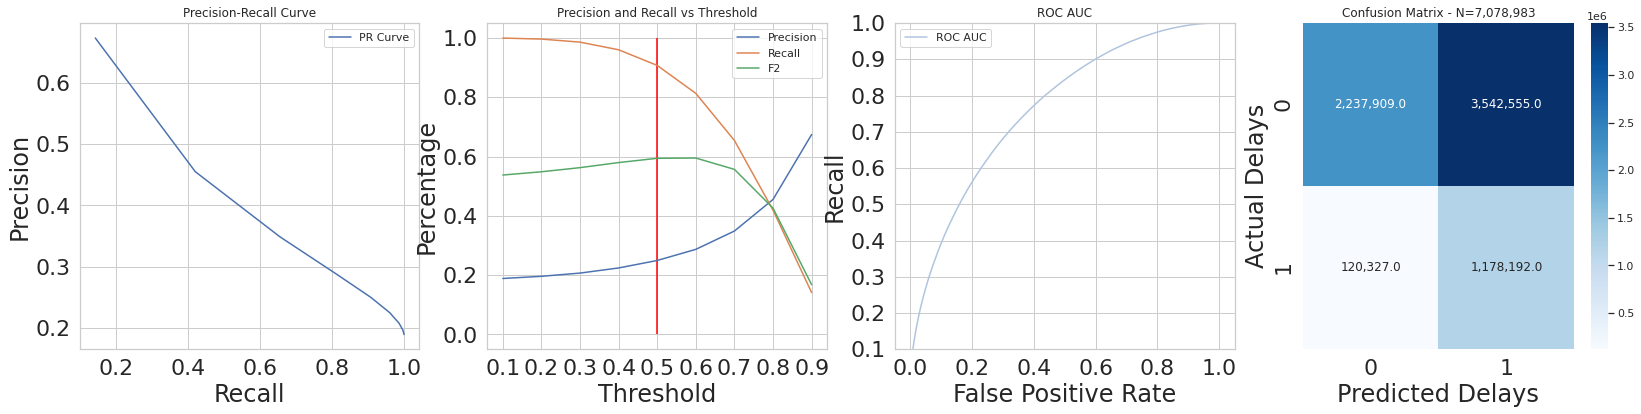

In [0]:
# evaluate best hyperparameter model using PR ROC AUC and other metrics 
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Best Extreme Gradient Boosted")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


#### Feature importance of best param XGboost

Number of Features
61
Out[163]:

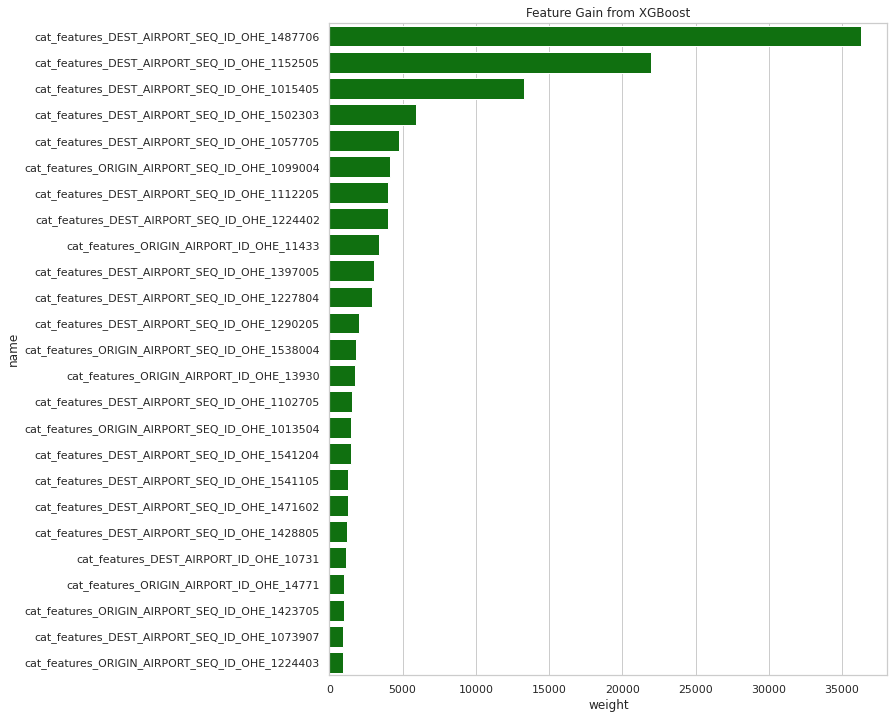

Text(0.5, 1.0, 'Feature Gain from XGBoost')

In [0]:
gain_values = best_xgb_model.stages[-1].get_booster().get_score(importance_type="gain")
index = [int(i[1:]) for i in gain_values.keys()]
save_features = {}
for i in test_pred.schema['features'].metadata['ml_attr']['attrs']['numeric']:
  save_features[i['idx']] = i['name']
for i in test_pred.schema['features'].metadata['ml_attr']['attrs']['binary']:
  save_features[i['idx']] = i['name']
  
feature_imp_dict = {}
for n, i in enumerate(index): 
  old_feat_ind = 'f' + str(i)
  feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
  
feature_df = pd.DataFrame.from_dict(feature_imp_dict, orient = 'index').reset_index()
feature_df.columns = ['name', 'weight']
 
print('Number of Features')
print(len(feature_df[feature_df.weight != 0]))
 
# Feature importance
sns.set(font_scale=1, style='whitegrid')
plt.subplots(figsize=(10,12))
ax = sns.barplot(x='weight', y='name', data=feature_df[(feature_df.weight != 0)].sort_values('weight', ascending = False).head(25), color='green')
ax.set_xlabel('weight')
ax.set_title('Feature Gain from XGBoost')


Number of Features
338
Out[113]:

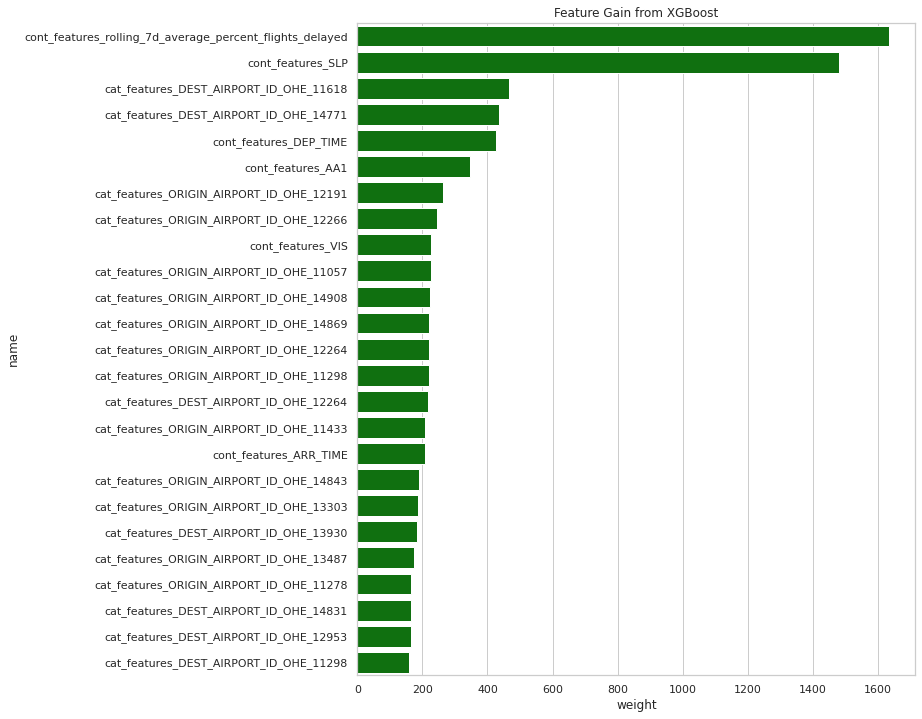

Text(0.5, 1.0, 'Feature Gain from XGBoost')

In [0]:
gain_values = xgboostModel.stages[-1].get_booster().get_score(importance_type="gain")
index = [int(i[1:]) for i in gain_values.keys()]
save_features = {}
for i in xgb_test_pred.schema['features'].metadata['ml_attr']['attrs']['numeric']:
  save_features[i['idx']] = i['name']
for i in xgb_test_pred.schema['features'].metadata['ml_attr']['attrs']['binary']:
  save_features[i['idx']] = i['name']
  
feature_imp_dict = {}
for n, i in enumerate(index): 
  old_feat_ind = 'f' + str(i)
  feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
  
feature_df = pd.DataFrame.from_dict(feature_imp_dict, orient = 'index').reset_index()
feature_df.columns = ['name', 'weight']
 
print('Number of Features')
print(len(feature_df[feature_df.weight != 0]))
 
# Feature importance
sns.set(font_scale=1, style='whitegrid')
plt.subplots(figsize=(10,12))
ax = sns.barplot(x='weight', y='name', data=feature_df[(feature_df.weight != 0)].sort_values('weight', ascending = False).head(25), color='green')
ax.set_xlabel('weight')
ax.set_title('Feature Gain from XGBoost')


## Test on Final Test Dataset 2019

In [0]:
# load full data up to 2018 to train
full_final_training_df = df_.filter(f.col('year') < 2019)
# test with 2019
full_final_test_df = df_.filter(f.col('year') == 2019)
display(full_final_training_df.limit(10))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEP_TIME DEP_DELAY_NEW DEP_DEL15 ARR_TIME ARR_DEL15 CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY AA1 AJ1 AL1 AO1 CB1 CF3 CG1 CT1 CU1 CV2 CW1 DEW ED1 ELEVATION GA2 GD2 GO1 IA1 KA1 KB1 KD2 MD1 ME1 MV2 MW1 RH3 SLP TMP VIS WA1 WD1 counter count_of_flights rolling_7d_average_number_of_flights rolling_7d_average_percent_flights_delayed rolling_7d_average_flights_distance OP_UNIQUE_CARRIER_index carrier_vec originid_vec destid_vec dayofweek_vec month_vec quarter_vec 2018 1 1 1 1 2018-01-01 9E 11298 1129806 12478 1247805 900 0.0 0.0 1309 0.0 0.0 0.0 214.0 189.0 1391.0 6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1 1 0.14285714285714285 0.0 1391.0 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(12478), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 13487 1348702 1139 0.0 0.0 1405 0.0 0.0 0.0 156.0 146.0 852.0 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -122.0 0.0 170.7 0.0 0.0 0.0 0.0 -44.0 0.0 0.0 7.0 0.0 0.0 0.0 0.0 10374.0 -44.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(13487), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 11193 1119302 1833 0.0 0.0 2138 0.0 0.0 0.0 134.0 125.0 812.0 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -144.0 0.0 170.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10352.0 -28.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11193), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 11433 1143302 1307 0.0 0.0 1735 1.0 0.0 0.0 162.0 208.0 986.0 4 0.0 0.0 43.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -122.0 0.0 170.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10373.0 -44.0 16093.0 0.0 0.0 1 6 0.8571428571428571 0.0 1069.6666666666667 13.0 Map(vectorType -> sparse, length -> 18, indices -> List(13), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11298), values -> List(1.0)) Map(vectorType -> sparse, length -> 16869, indices -> List(11433), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 12, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) 2018 1 1 2 2 2018-01-02 9E 11298 1129806 12478 12

### Final Logistic Regression

In [0]:
# add weight to minority class data to balance dataset
delayed_flights = full_final_training_df.selectExpr("label").filter(f.col("label") == 1)
sample_ratio = delayed_flights.count() / full_final_training_df.count() 
delayed_weight = 1 - sample_ratio
ontime_weight = sample_ratio

weighted_full_final_training_df = full_final_training_df.withColumn("label_weight", when(full_final_training_df.label == 1, delayed_weight).otherwise(ontime_weight))

print('delay ratio of %.4f' % sample_ratio)

# create model, use reg param of 0.1
final_lr = LogisticRegression(regParam=0.1, weightCol="label_weight")

Fraction of positives in the dataset is 0.1801

In [0]:
# final LR pipeline
columns_numerical = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           

assembler_cont = VectorAssembler(inputCols=columns_numerical, outputCol="cont_features")

scaler = StandardScaler(inputCol="cont_features",  outputCol="scaled_cont_features", withStd=True, withMean=True)

columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]

indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical], handleInvalid='keep')

ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])

assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")

selector = ChiSqSelector(fpr=0.05, selectorType='fpr', featuresCol="cat_features", outputCol="selected_cat_features", labelCol="label")

assembler = VectorAssembler(inputCols= ["selected_cat_features", "scaled_cont_features"], outputCol="features")

pipeline_final_lr = Pipeline(stages=[assembler_cont, scaler, indexer, ohe, assembler_categ, selector, assembler, final_lr]) 

In [0]:
# fit model to pipeline
final_lr_model = pipeline_final_lr.fit(weighted_full_final_training_df)

In [0]:
# Predict with test data
train_pred = final_lr_model.transform(full_final_training_df)
test_pred = final_lr_model.transform(full_final_test_df)

Final Logistic Regression
 Train Test
PR AUC 0.38219 0.37804
ROC AUC 0.73077 0.72107
F1 Score 0.42158 0.42029
F2 Score 0.54324 0.54452
Recall 0.67265 0.67816
Precision 0.30699 0.30451
Accuracy 0.66764 0.65163
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

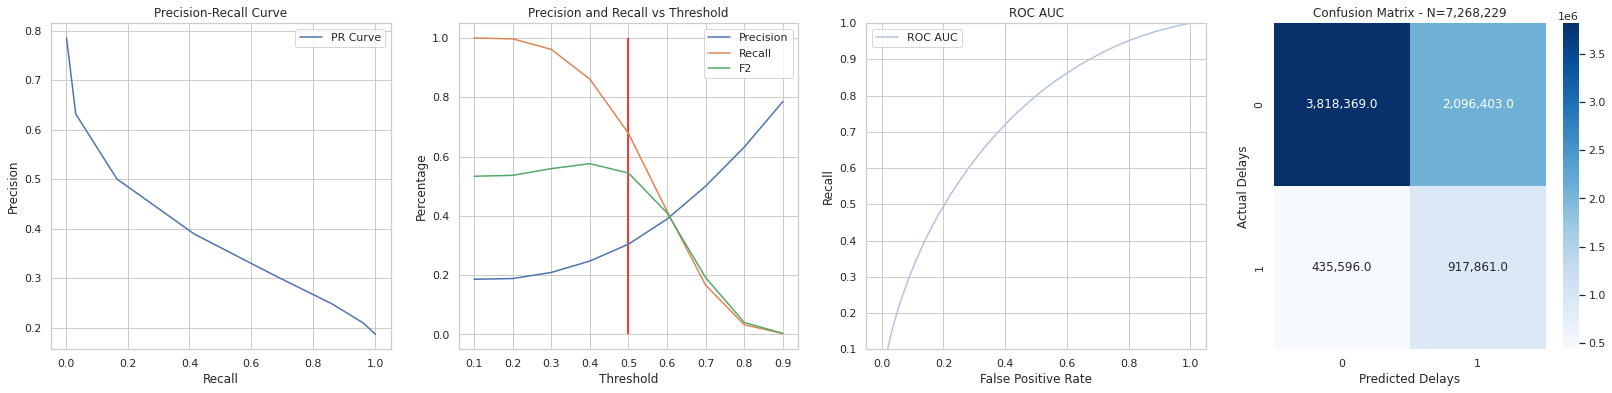

In [0]:
# evaluate final LR model
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Final Logistic Regression")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

# plot results PR curve, ROC AUC and confusion matrix
# plot the Precision-Recall curve  
sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


### Final Gradient Boosted Treee

In [0]:
# reload dataset
full_final_training_df = df_.filter(f.col('year') < 2019)
full_final_test_df = df_.filter(f.col('year') == 2019)

# downsample dataset to balance the final full training datset up to 2018
delay_count = full_final_training_df.filter(f.col("label") == 1).count()
non_delay_count = full_final_training_df.filter(f.col("label") == 0).count()
keep_percent = delay_count / non_delay_count
train_delay = full_final_training_df.filter(f.col('label') == 1)
train_non_delay = full_final_training_df.filter(f.col('label') == 0).sample(fraction=keep_percent, seed=261)
weighted_full_final_training_df = train_delay.union(train_non_delay)



In [0]:
# create gbt with best param discovered
final_gbt = GBTClassifier(maxDepth=8, maxBins=280, maxIter=6, stepSize=0.2)

In [0]:
# Pipeline for Final GBT

# Continuous features 
columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           

assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")

# Categorical Features that need to be indexed and then ohe
columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]

indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])

assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")

assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

pipeline_final_gbt = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, final_gbt]) 
 

In [0]:
# fit model
final_gbt_model = pipeline_final_gbt.fit(weighted_full_final_training_df)

In [0]:
# train transform and predict
train_pred = final_gbt_model.transform(full_final_training_df)
test_pred = final_gbt_model.transform(full_final_test_df)

Final Gradient Boosted Tree
 Train Test
PR AUC 0.45391 0.45358
ROC AUC 0.76387 0.75528
F1 Score 0.44373 0.44036
F2 Score 0.56775 0.56994
Recall 0.69777 0.70904
Precision 0.32529 0.31935
Accuracy 0.68497 0.66440
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

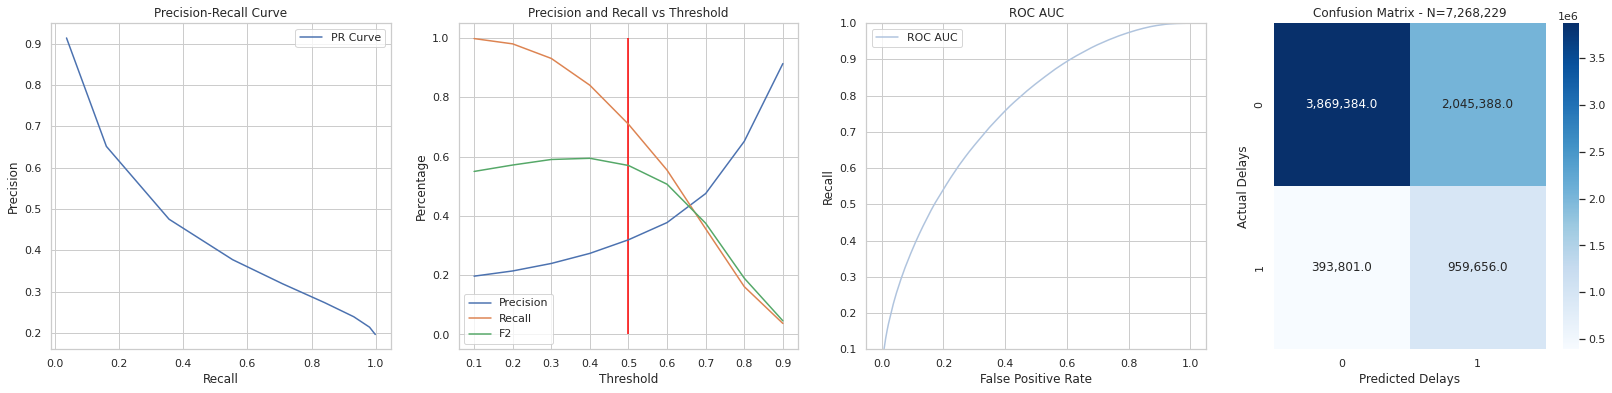

In [0]:
# evaluate final Gradient Boosted Tree
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Final Gradient Boosted Tree")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   


In [0]:
# create final XGBoost model with best hyperparameters
final_xgboost = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability',
                            max_depth = 6,
                            n_estimators = 150,
                            reg_lambda = 1,
                            reg_alpha = 0,
                            objective='binary:logistic',
                            base_score = 0.5,
                            learning_rate = 0.3,
                            gamma = 0.05,
                            scale_pos_weight = 2,
                            min_child_weight = 1.5)
# pipeline for final XGBoost
columns_numeric = ["YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","DEP_TIME","ARR_TIME","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP","AA1","AJ1","AL1","AO1","CB1","CF3","CG1","CT1","CU1","CV2","CW1","DEW","ED1","ELEVATION","GA2","GD2","GO1","IA1","KA1","KB1","KD2","MD1","ME1","MV2","MW1","RH3","SLP","TMP","VIS","WA1","WD1","count_of_flights","rolling_7d_average_number_of_flights","rolling_7d_average_percent_flights_delayed","rolling_7d_average_flights_distance"]           

assembler_cont = VectorAssembler(inputCols=columns_numeric, outputCol="cont_features")

columns_categorical = ["ORIGIN_AIRPORT_ID","ORIGIN_AIRPORT_SEQ_ID","DEST_AIRPORT_ID","DEST_AIRPORT_SEQ_ID"]

indexer = StringIndexer(inputCols=columns_categorical, outputCols=[c+"_indexed" for c in columns_categorical]).setHandleInvalid("keep")

ohe = OneHotEncoder(inputCols=[c+"_indexed" for c in columns_categorical], outputCols= [c+"_OHE" for c in columns_categorical])

assembler_categ = VectorAssembler(inputCols= [x+"_OHE" for x in columns_categorical], outputCol="cat_features")

assembler = VectorAssembler(inputCols= ["cat_features", "cont_features"], outputCol="features")

pipeline_final_xgb = Pipeline(stages=[assembler_cont, indexer, ohe, assembler_categ, assembler, final_xgboost]) 

In [0]:
# fit model
final_xgb_model = pipeline_final_xgb.fit(weighted_full_final_training_df)

# transform and predict
train_pred = final_xgb_model.transform(full_final_training_df)
test_pred = final_xgb_model.transform(full_final_test_df)


Final Extreme Gradient Boosted
 Train Test
PR AUC 0.50659 0.49011
ROC AUC 0.79441 0.77734
F1 Score 0.40977 0.40627
F2 Score 0.60948 0.60632
Recall 0.90280 0.90264
Precision 0.26503 0.26212
Accuracy 0.53169 0.50870
 Validation Plots
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

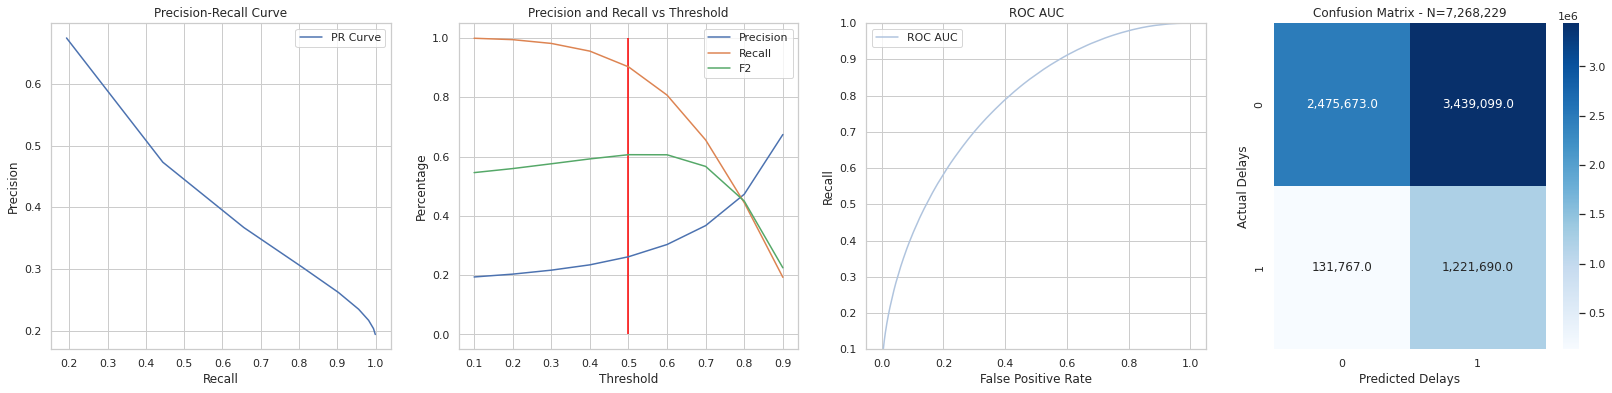

In [0]:
# Evalaute Final XGB
rdd_train_binary = train_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_valid_binary = test_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rdd_train_multi = train_pred.select(['prediction', 'label']).rdd
rdd_valid_multi = test_pred.select(['prediction', 'label']).rdd

metrics_binary_train = BinaryClassificationMetrics(rdd_train_binary)
metrics_binary_valid = BinaryClassificationMetrics(rdd_valid_binary)
metrics_multi_train = MulticlassMetrics(rdd_train_multi)
metrics_multi_valid = MulticlassMetrics(rdd_valid_multi)

# pull metrics
results_pddf = pd.DataFrame({
                      ' '         : ['Train', 'Test'],
                      'PR AUC'    : [metrics_binary_train.areaUnderPR, metrics_binary_valid.areaUnderPR],
                      'ROC AUC'   : [metrics_binary_train.areaUnderROC, metrics_binary_valid.areaUnderROC],
                      'F1 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=1.0), metrics_multi_valid.fMeasure(1.0, beta=1.0)],
                      'F2 Score'  : [metrics_multi_train.fMeasure(label=1.0, beta=2.0), metrics_multi_valid.fMeasure(1.0, beta=2.0)],
                      'Recall'    : [metrics_multi_train.recall(label=1), metrics_multi_valid.recall(label=1)],
                      'Precision' : [metrics_multi_train.precision(1), metrics_multi_valid.precision(1)],
                      'Accuracy'  : [metrics_multi_train.accuracy, metrics_multi_valid.accuracy]})
results_pddf = results_pddf.set_index(' ')

# print/plot results & pprint results
pd.set_option("display.precision", 5)
print("Final Extreme Gradient Boosted")
print(results_pddf.T)
print('                                        Validation Plots')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6))

pr_results = []
preds_new = test_pred
preds_new = preds_new.withColumn('pred_probability', firstelement('probability'))
thresholds = np.arange(start=0.1, stop=1.1, step=0.1)
c = [f'c{i}' for i in range(1,11)]
i = 0
for threshold in thresholds:
  preds_new = preds_new.withColumn(c[i], f.when(preds_new["pred_probability"].cast(DoubleType()) >= threshold , 1.0).otherwise(0.0).cast(DoubleType()))
  i += 1
for i in range(len(thresholds) - 1):                       
  metrics_multi = MulticlassMetrics(preds_new.select([c[i], 'label']).rdd)
  precision = metrics_multi.precision(1)
  recall = metrics_multi.recall(label=1)
  f2 = metrics_multi.fMeasure(1.0, 2.0)
  pr_results.append((thresholds[i], precision, recall, f2))
  
preds_test_pr = pd.DataFrame(pr_results).rename(columns={0:'Threshold', 1:'Precision', 2:'Recall', 3:'f2-score'})

sns.set(font_scale=1, style='whitegrid')
sns.lineplot(x='Recall', y='Precision', data=preds_test_pr, label='PR Curve', ax=axes[0])
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

sns.lineplot(x='Threshold',y='Precision',data=preds_test_pr,label='Precision',ax=axes[1])
sns.lineplot(x='Threshold',y='Recall',data=preds_test_pr,label='Recall',ax=axes[1])
sns.lineplot(x='Threshold',y='f2-score',data=preds_test_pr,label='F2',ax=axes[1])
axes[1].vlines(0.5,0,1,color='red')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Precision and Recall vs Threshold')
axes[1].legend()

# plot ROC AUC
points_roc = CurveMetrics(rdd_valid_binary).get_curve('roc')
x_val = [x[0] for x in points_roc]
y_val = [x[1] for x in points_roc]
sns.lineplot(x_val, y_val, color='lightsteelblue',label='ROC AUC',ax= axes[2])
axes[2].set_ylim([0.1, 1])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('Recall')
axes[2].set_title('ROC AUC')
axes[2].legend()

# Plot confusion matrix
confusion_matrix = pd.DataFrame(metrics_multi_valid.confusionMatrix().toArray())
sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes[3])
size = int(test_pred.count())
size = f'{size:,}'
axes[3].set_title('Confusion Matrix - N={}'.format(size))
axes[3].set_ylabel('Actual Delays')
axes[3].set_xlabel('Predicted Delays')
plt.show()   

Number of Features
61
Out[216]:

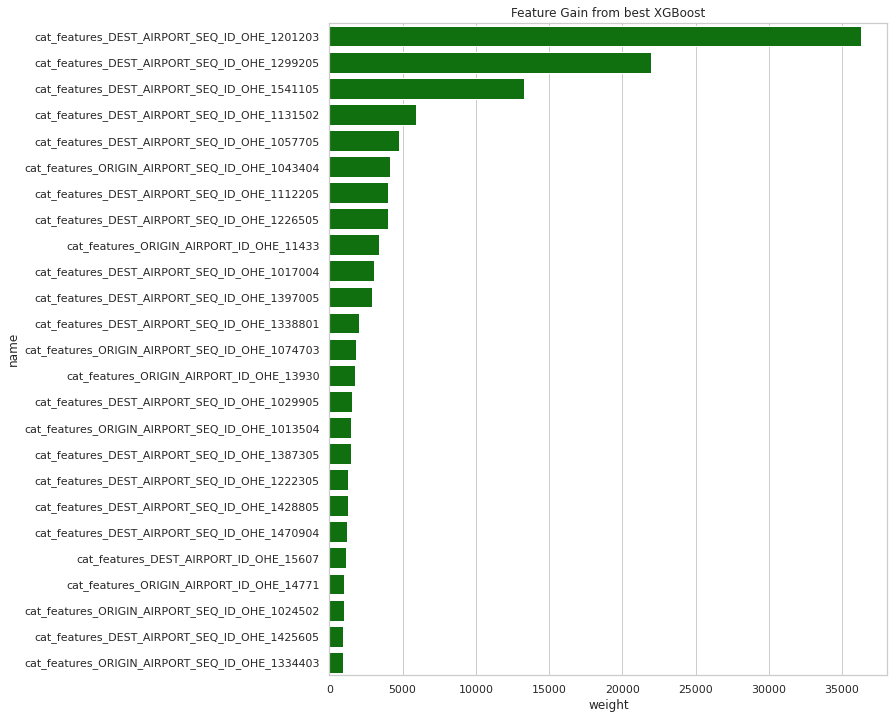

Text(0.5, 1.0, 'Feature Gain from best XGBoost')

In [0]:
# feature importance
gain_values = best_xgb_model.stages[-1].get_booster().get_score(importance_type="gain")
index = [int(i[1:]) for i in gain_values.keys()]
save_features = {}
for i in test_pred.schema['features'].metadata['ml_attr']['attrs']['numeric']:
  save_features[i['idx']] = i['name']
for i in test_pred.schema['features'].metadata['ml_attr']['attrs']['binary']:
  save_features[i['idx']] = i['name']
  
feature_imp_dict = {}
for n, i in enumerate(index): 
  old_feat_ind = 'f' + str(i)
  feature_imp_dict[save_features[i]] = gain_values[old_feat_ind]
  
feature_df = pd.DataFrame.from_dict(feature_imp_dict, orient = 'index').reset_index()
feature_df.columns = ['name', 'weight']
 
print('Number of Features')
print(len(feature_df[feature_df.weight != 0]))
 
# Feature importance
sns.set(font_scale=1, style='whitegrid')
plt.subplots(figsize=(10,12))
ax = sns.barplot(x='weight', y='name', data=feature_df[(feature_df.weight != 0)].sort_values('weight', ascending = False).head(25), color='green')
ax.set_xlabel('weight')
ax.set_title('Feature Gain from best XGBoost')
